# pyplearnr demo
Here I demonstrate pyplearnr, a wrapper for building/training/validating scikit learn pipelines using GridSearchCV or RandomizedSearchCV.

Quick keyword arguments give access to optional feature selection (e.g. SelectKBest), scaling (e.g. standard scaling), use of feature interactions, and data transformations (e.g. PCA, t-SNE) before being fed to a classifier/regressor.

After building the pipeline, data can be used to perform a nested (stratified if classification) k-folds cross-validation and output an object containing data from the process, including the best model.

Various default pipeline step parameters for the grid-search are available for quick iteration over different pipelines, with the option to ignore/override them in a flexible way.

This is an on-going project that I intend to update with more models and pre-processing options and also with corresponding defaults.

## Titanic dataset example
Here I use the Titanic dataset I've cleaned and pickled in a separate tutorial.

### Import data

In [1]:
import pandas as pd

df = pd.read_pickle('trimmed_titanic_data.pkl')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 9 columns):
Survived    890 non-null int64
Pclass      890 non-null int64
Sex         890 non-null object
Age         890 non-null float64
SibSp       890 non-null int64
Parch       890 non-null int64
Fare        890 non-null float64
Embarked    890 non-null object
Title       890 non-null object
dtypes: float64(2), int64(4), object(3)
memory usage: 69.5+ KB


By "cleaned" I mean I've derived titles (e.g. "Mr.", "Mrs.", "Dr.", etc) from the passenger names, imputed the missing Age values using polynomial regression with grid-searched 10-fold cross-validation, filled in the 3 missing Embarked values with the mode, and removed all fields that could be considered an id for that individual.

Thus, there is no missing/null data.

## Set categorical features as type 'category'
In order to one-hot encode categorical data, its best to set the features that are considered categorical:

In [2]:
simulation_df = df.copy()

categorical_features = ['Survived','Pclass','Sex','Embarked','Title']

for feature in categorical_features:
    simulation_df[feature] = simulation_df[feature].astype('category')
    
simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 9 columns):
Survived    890 non-null category
Pclass      890 non-null category
Sex         890 non-null category
Age         890 non-null float64
SibSp       890 non-null int64
Parch       890 non-null int64
Fare        890 non-null float64
Embarked    890 non-null category
Title       890 non-null category
dtypes: category(5), float64(2), int64(2)
memory usage: 39.3 KB


## One-hot encode categorical features

In [3]:
simulation_df = pd.get_dummies(simulation_df,drop_first=True)

simulation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 890 entries, 0 to 890
Data columns (total 17 columns):
Age               890 non-null float64
SibSp             890 non-null int64
Parch             890 non-null int64
Fare              890 non-null float64
Survived_1        890 non-null uint8
Pclass_2          890 non-null uint8
Pclass_3          890 non-null uint8
Sex_male          890 non-null uint8
Embarked_Q        890 non-null uint8
Embarked_S        890 non-null uint8
Title_Dr          890 non-null uint8
Title_Military    890 non-null uint8
Title_Miss        890 non-null uint8
Title_Mr          890 non-null uint8
Title_Mrs         890 non-null uint8
Title_Noble       890 non-null uint8
Title_Rev         890 non-null uint8
dtypes: float64(2), int64(2), uint8(13)
memory usage: 46.1 KB


Now we have 17 features.

### Split into input/output data

In [4]:
# Set output feature
output_feature = 'Survived_1'

# Get all column names
column_names = list(simulation_df.columns)

# Get input features
input_features = [x for x in column_names if x != output_feature]

# Split into features and responses
X = simulation_df[input_features].copy()
y = simulation_df[output_feature].copy()

### Null model

In [5]:
simulation_df['Survived_1'].value_counts().values/float(simulation_df['Survived_1'].value_counts().values.sum())

array([ 0.61573034,  0.38426966])

Thus, null accuracy of ~62% if always predict death.

### Import pyplearnr and initialize optimized pipeline collection

In [6]:
%matplotlib inline

%load_ext autoreload

import sys

import os

sys.path.append("./pyplearnr")

optimized_pipelines = {}

In [7]:
%%time 
%autoreload

import numpy as np
import pyplearnr as ppl

reload(ppl)

kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=5, 
                                      inner_loop_fold_count=5)

pipeline_bundle_schematic = [
    {'scaler': {
        'none': {},
        'standard': {},
        'normal': {},
        'min_max': {},
        'binary': {}
    }},
    {'estimator': {
            'knn': {
                'n_neighbors': range(1,30)
            },
#         'svm': {
#             'C': np.array([1.00000000e+00])
#         }
    }}
]

pipelines = ppl.PipelineBuilder().build_pipeline_bundle(pipeline_bundle_schematic)

print 'Number of pipelines: %d'%(len(pipelines)), '\n'

kfcv.fit(X.values, y.values, pipelines, scoring_metric='auc')

Number of pipelines: 145 

Outer Fold: 1 

6 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform'))])
122 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='uniform'))])


No model was chosen because there is no clear winner. Please use the same fit method with best_inner_fold_pipeline_inds keyword argument.

Example:	kfcv.fit(X.values, y.values, pipelines)
		kfcv.fit(X.values, y.values, pipelines, 
			 best_inner_fold_pipeline_inds = {0:9, 2:3})

CPU times: user 54.9 s, sys: 603 ms, total: 55.5 s
Wall time: 57.4 s


In [8]:
%autoreload
kfcv.fit(X.values, y.values, pipelines, 
			 best_inner_fold_pipeline_inds = {1:6})

8 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='uniform'))])
121 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform'))])
120 Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
6 Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_job

In [9]:
kfcv.fit(X.values, y.values, pipelines, best_outer_fold_pipeline=8)


--------------------------------------------------------------------------------
Best pipeline: 8
--------------------------------------------------------------------------------
----------------------  --------------------------------------------------------
Validation performance  Inner-loop scores
----------------------  --------------------------------------------------------
                                    OF0       OF1       OF2       OF3       OF4
  0%    0.7345             0%    0.7261    0.7203    0.7273    0.7225    0.7398
 25%    0.7353            25%    0.7909    0.7307    0.7523    0.7341     0.792
 50%    0.7971            50%    0.8014    0.7727     0.833    0.7932     0.833
 75%    0.8236            75%    0.8148    0.7955     0.833    0.8375    0.8337
100%    0.8513           100%    0.8352    0.8442    0.8358    0.8477    0.8364
----------------------  --------------------------------------------------------
mean    0.7883           mean    0.7937    0.7727    0.

In [ ]:
%autoreload

%matplotlib inline

kfcv.plot_best_pipeline_scores(number_size=18, markersize=14)

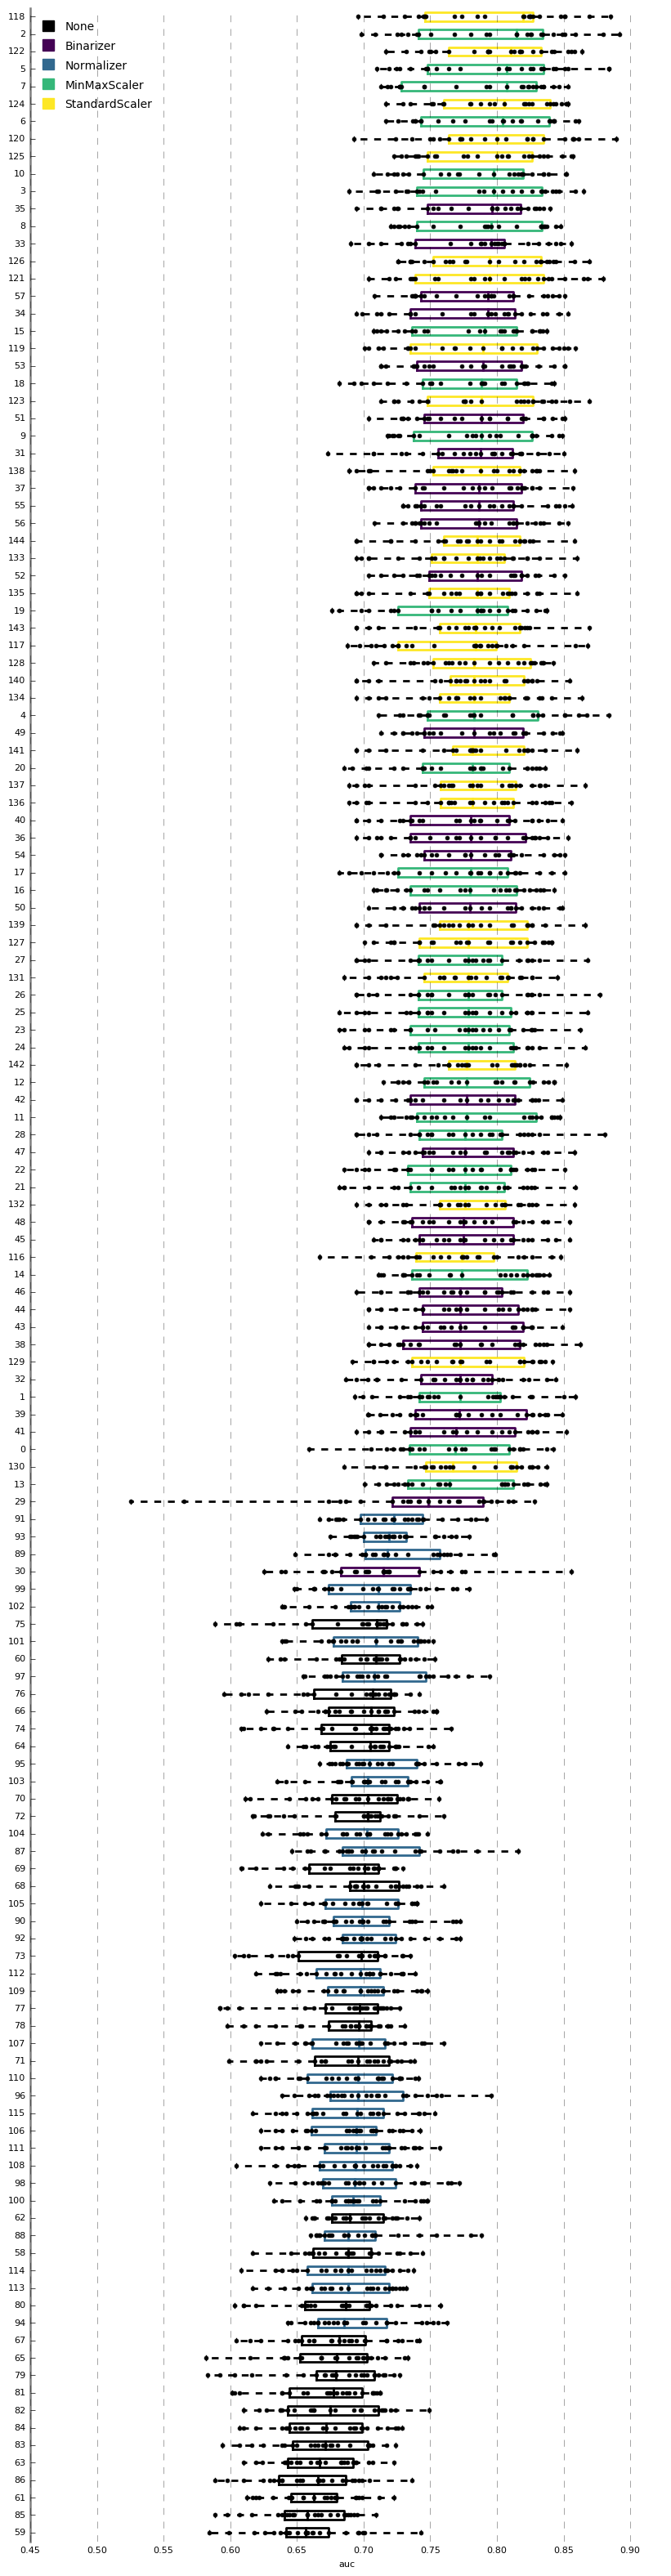

In [33]:
%autoreload

%matplotlib inline

kfcv.plot_contest(number_size=8, markersize=7, all_folds=True, figsize=(10,40), 
                  color_by='scaler') #'scaler'

In [32]:
kfcv.pipelines[29]

Pipeline(steps=[('scaler', Binarizer(copy=True, threshold=0.0)), ('estimator', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])

In [ ]:

# cmap = pylab.cm.viridis

# print cmap.__doc__

In [ ]:
worst_pipelines = [85, 67, 65, 84, 69, 83]

for pipeline_ind in worst_pipelines:
    print pipeline_ind, kfcv.pipelines[pipeline_ind]
    
print '\n'

worst_pipelines = [86, 75, 84, 79, 85, 83]

for pipeline_ind in worst_pipelines:
    print pipeline_ind, kfcv.pipelines[pipeline_ind]

print '\n'

worst_pipelines = [77, 61, 81, 83, 74, 82, 84]

for pipeline_ind in worst_pipelines:
    print pipeline_ind, kfcv.pipelines[pipeline_ind]


In [ ]:
best_pipelines = [89, 93, 2, 91, 4, 3]

for pipeline_ind in best_pipelines:
    print pipeline_ind, kfcv.pipelines[pipeline_ind]
    
print '\n'

best_pipelines = [91, 93, 5, 43, 4, 100]

for pipeline_ind in best_pipelines:
    print pipeline_ind, kfcv.pipelines[pipeline_ind]

print '\n'

best_pipelines = [5, 4, 91, 3, 55, 49, 2]

for pipeline_ind in best_pipelines:
    print pipeline_ind, kfcv.pipelines[pipeline_ind]


In [ ]:
%%time 
%autoreload

import numpy as np
import pyplearnr as ppl

reload(ppl)

kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=3, 
                                      inner_loop_fold_count=3)

pipeline_bundle_schematic = [
    {'scaler': {
        'standard': {},
        'normal': {},
        'min_max': {},
        'binary': {}
    }},
    {'estimator': {
            'knn': {
                'n_neighbors': range(1,30)
            },
#         'svm': {
#             'C': np.array([1.00000000e+00])
#         }
    }}
]

pipelines = ppl.PipelineBuilder().build_pipeline_bundle(pipeline_bundle_schematic)

print 'Number of pipelines: %d'%(len(pipelines)), '\n'

kfcv.fit(X.values, y.values, pipelines, scoring_metric='accuracy')

In [ ]:
kfcv.fit(X.values, y.values, pipelines, 
			 best_inner_fold_pipeline_inds = {1:24, 2:55})

In [ ]:
kfcv.fit(X.values, y.values, pipelines, best_outer_fold_pipeline=55)

In [ ]:
%autoreload

%matplotlib inline

kfcv.plot_best_pipeline_scores()

In [ ]:
%autoreload

%matplotlib inline

kfcv.plot_contest()

In [ ]:
best_pipelines = [91, 44, 89, 45, 3, 90]

for pipeline_ind in best_pipelines:
    print pipeline_ind, kfcv.pipelines[pipeline_ind]
    
print '\n'

best_pipelines = [21, 18, 40, 38, 36, 35, 24]

for pipeline_ind in best_pipelines:
    print pipeline_ind, kfcv.pipelines[pipeline_ind]

print '\n'

best_pipelines = [55, 39, 41, 42, 47, 40, 114, 110]

for pipeline_ind in best_pipelines:
    print pipeline_ind, kfcv.pipelines[pipeline_ind]


In [ ]:
%autoreload
kfcv.print_report()

In [ ]:
kfcv.fit(X.values, y.values, pipelines, 
			 best_inner_fold_pipeline_inds = {2:18})

In [ ]:
kfcv.fit(X.values, y.values, pipelines, best_outer_fold_pipeline=18)

In [ ]:
%autoreload
kfcv.print_report()

In [ ]:
best_inner_fold_pipelines = {
    2: 9
}

kfcv.fit(X.values, y.values, pipelines, 
         best_inner_fold_pipeline_inds = best_inner_fold_pipelines)

In [ ]:
best_outer_fold_pipeline = 45

kfcv.fit(X.values, y.values, pipelines, 
         best_outer_fold_pipeline = best_outer_fold_pipeline)

# Regression

In [ ]:
%%time 
%autoreload

import numpy as np
import pyplearnr as ppl

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

reload(ppl)

data = pd.read_csv('Advertising.csv',index_col=0)

# Start with all features
feature_cols = ['TV','Radio','Newspaper']

# Split data
X = data[feature_cols]
y = data.Sales

kfcv = ppl.NestedKFoldCrossValidation(outer_loop_fold_count=5, 
                                      inner_loop_fold_count=3)

pipeline_bundle_schematic = [
    {'scaler': {
        'none': {},
        'standard': {}
    }},
    {'pre_estimator': {
            'polynomial_features': {
                'degree': range(1,5)
            }
        }},
    {'estimator': {
            'linear_regression': {},
    }}
]

pipelines = ppl.PipelineBuilder().build_pipeline_bundle(pipeline_bundle_schematic)
    
print 'Number of pipelines: %d'%(len(pipelines)), '\n'

kfcv.fit(X.values, y.values, pipelines, scoring_metric='rmse')

In [ ]:
kfcv.fit(X.values, y.values, pipelines, scoring_metric='rmse', best_outer_fold_pipeline=1)

In [ ]:
%autoreload
kfcv.print_report()

In [ ]:
%autoreload
kfcv.print_report()

In [ ]:
%%time
%autoreload
import itertools

estimators = ['knn','logistic_regression','svm',
              'multilayer_perceptron','random_forest','adaboost']

feature_interaction_options = [True,False]
feature_selection_options = [None,'select_k_best']
scaling_options = [None,'standard','normal','min_max','binary']
transformations = [None,'pca']

pipeline_steps = [feature_interaction_options,feature_selection_options,scaling_options,
                  transformations,estimators]

pipeline_options = list(itertools.product(*pipeline_steps))

optimized_pipelines = {}

for pipeline_step_combo in pipeline_options:
    model_name = []
    
    feature_interactions = pipeline_step_combo[0]
    
    if feature_interactions:
        model_name.append('interactions')
        
    feature_selection_type = pipeline_step_combo[1]
    
    if feature_selection_type:
        model_name.append('select')
    
    scale_type = pipeline_step_combo[2]
    
    if scale_type:
        model_name.append(scale_type)
        
    transform_type = pipeline_step_combo[3]
    
    if transform_type:
        model_name.append(transform_type)
        
    estimator = pipeline_step_combo[4]
    
    model_name.append(estimator)
    
    model_name = '_'.join(model_name)
    
    print model_name
    
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': feature_selection_type,
        'scale_type': scale_type,
        'transform_type': transform_type
        }

    # Initialize pipeline
    optimized_pipeline = ppl.PipelineOptimization(estimator,**optimized_pipeline_kwargs)

    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': None,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2 # 20% saved as test set
    }

    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)

    # Save optimized pipeline
    optimized_pipelines[model_name] = optimized_pipeline

### KNN with and without pre-processing and various options
#### Basic KNN
Here we do a K-nearest neighbors (KNN) classification with stratified 10-fold (default) cross-validation with a grid search over the default of 1 to 30 nearest neighbors and the use of either "uniform" or "distance" weights:

In [ ]:
%%time

estimator = 'knn'

# Set pipeline keyword arguments
optimized_pipeline_kwargs = {
    'feature_selection_type': None,
    'scale_type': None,
    'transform_type': None
    }

# Initialize pipeline
optimized_pipeline = ppl.PipelineOptimization(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'cv': 10,
    'num_parameter_combos': None,
    'n_jobs': -1,
    'random_state': 6,
    'suppress_output': True,
    'use_default_param_dist': True,
    'param_dist': None,
    'test_size': 0.2 # 20% saved as test set
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[estimator] = optimized_pipeline

Note the default OptimizedPipeline parameters and those for its fit() method.

The OptimizedPipeline class contains all of the data associated with the nested stratified k-folds cross-validation.

After use of the fit() method, this includes the data, its test/train splits (based on the test_size percentage keyword argument), the GridSearchCV or RandomizedGridSearchCV object, the Pipeline object that has been retrained using all of the data with the best parameters, test/train scores, and validation metrics/reports.

A report can be printed immediately after the fit by setting the suppress_output keyword argument to True. 

Printing the OptimizedPipeline instance also shows the report:

In [ ]:
print optimized_pipeline

The report lists the steps in the pipeline, their optimized settings, the test/training accuracy (or L2 regression score), the grid search parameters, and the best parameters.

If the estimator used is a classifier it also includes the confusion matrix, normalized confusion matrix, and a classification report containing precision/recall/f1-score for each class.

Turns out that the best settings for this optimized pipeline are 12 neighbors and the use of the 'uniform' weight.

Note how I've set the random_state keyword agument to 6 so that the models can be compared using the same test/train split.

#### Default pipeline step grid parameters
The default parameters to grid-search over for k-nearest neighbors are 1 to 30 neighbors and either the 'uniform' or 'distance' weight.

The defaults for the pre-processing steps, classifiers, and regressors can be viewed by using the get_default_pipeline_step_parameters() method with the number of features as the input:

In [ ]:
pre_processing_grid_parameters,classifier_grid_parameters,regression_grid_parameters = \
optimized_pipeline.get_default_pipeline_step_parameters(X.shape[0])

classifier_grid_parameters['knn']

#### KNN with custom pipeline step grid parameters
These default parameters can be ignored by setting the use_default_param_dist keyword argument to False. 

The param_dist keyword argument can be used to keep default parameters (if use_default_param_dist set to True) or to be used as the sole source of parameters (if use_default_param_dist set to False). 

Here is a demonstration of generation of default parameters with those in param_dist being overridden:

In [ ]:
%%time

estimator_name = 'knn'

model_name = 'custom_override_%s'%(estimator_name)

# Set custom parameters
param_dist = {
    'estimator__n_neighbors': range(30,500)
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'param_dist': param_dist,
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline

Note how the n_neighbors parameter was 30 to 499 instead of 1 to 30.

Here's an example of only using param_dist for parameters:

In [ ]:
%%time

model_name = 'from_scratch_%s'%(estimator_name)

# Set custom parameters
param_dist = {
    'estimator__n_neighbors': range(10,30)
}

estimator = 'knn'

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': False,
    'param_dist': param_dist,
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline

Note how the estimator\_\_weights parameter isn't set for the KNN estimator.

### KNN with scaling
The currently supported scaling options are standard, normal, min-max, and binary using scikit-learn's StandardScaler, Normalizer, MinMaxScaler, and Binarizer, respectively. These are set by the pipeline initialization kwarg 'scale_type' like this:

In [ ]:
%%time

estimator = 'knn'

scaling_options = ['standard','normal','min-max','binary']

for scaling_option in scaling_options:
    model_name = '%s_%s'%(scaling_option,estimator_name)
    
    optimized_pipeline_kwargs = {
        'scale_type': scaling_option
    }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

    # Set pipeline fitting parameters
    fit_kwargs = {
        'random_state': 6,
        'use_default_param_dist': True,
        'suppress_output': True
        
    }

    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)

    # Save 
    optimized_pipelines[model_name] = optimized_pipeline

Let's compare the pipelines so far:

In [ ]:
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

Binary scaling fed into a KNN classifier appears to have the best training score.

#### KNN with custom min-max and binary scaling settings
MinMaxScaler scales each feature value to between 0 and 1 by default. Different scaling ranges can be gridded over by setting the 'scaler\_\_feature_range' keyword argument in param_dist.

Binarizer sets each value to 0 or 1 depending on a threshold. The default for pyplearnr is 0.5. This can be changed by setting 'scaler\_\_threshold' using param_dist.

Here is an example of setting both:

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

scaling_options = ['min_max','binary']

param_dists = {
    'min_max': {
        'scaler__feature_range': [(1,2),(3,4)]
    },
    'binary': {
        'scaler__threshold': np.arange(0,1,0.1)
    }
}

for scaling_option in scaling_options:
    model_name = 'custom_%s_%s'%(scaling_option,estimator_name)
    
    optimized_pipeline_kwargs = {
        'scale_type': scaling_option
    }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'random_state': 6,
        'use_default_param_dist': True,
        'suppress_output': True,
        'param_dist': param_dists[scaling_option]
        
    }

    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)

    # Save 
    optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

Switching the range for min_max scaling boosted it to rank 1 for pipeline training scores:

In [ ]:
print optimized_pipelines['custom_min_max_knn']

The range of 1 to 2 for the MinMaxScaler appeared to be the best.

### KNN with feature selection using SelectKBest with f_classif
Currently only one form of feature selection, SelectKBest with f_classif, is supported. This is set using the 'feature_selection_type' keyword argument.

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'select_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'feature_selection_type': 'select_k_best'
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

Feature selection and KNN did had a mid-level training score:

In [ ]:
print optimized_pipelines['select_knn']

SelectKBest with f_classif chose 5 features as the best to use in the model.

The features selected by SelectKBest can be accessed normally, using the mask obtained from the get_support() method on the columns:

In [ ]:
feature_selection_mask = optimized_pipelines['select_knn'].pipeline.named_steps['feature_selection'].get_support()

print np.array(X.columns)[feature_selection_mask]

Thus, Pclass 3, being male, and the titles Miss, Mr, and Mrs were considered the most important features by SelectKBest using f_classif.

#### Setting custom feature selection
The default number of features is 1 to all of them. This can be gridded over different values by setting 'feature_selection\_\_k' in param_dist:

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'custom_select_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'feature_selection_type': 'select_k_best'
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

param_dist = {
    'feature_selection__k': [5,7,8]
}

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True,
    'param_dist': param_dist
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

In [ ]:
print optimized_pipelines['custom_select_knn']

### KNN using feature interactions
Feature products of different degrees can be used as additional features by setting the 'feature_interaction' OptimizedPipeline keyword argument to True:

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'interaction_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'feature_interactions': True
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

In [ ]:
print optimized_pipelines['interaction_knn']

The optimal number of interactions (number of features multiplied by each other at once) was found to be 1.

#### KNN using custom number of feature interactions
The 'feature_interactions__degree' dictates the number of interactions. The default setting is to try no interactions (degree 1) and 2 interactions. Setting this in param_dist allows custom numbers:

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'custom_interaction_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'feature_interactions': True
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

param_dist = {
    'feature_interactions__degree': [2,3,4]
}

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True,
    'param_dist': param_dist
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

In [ ]:
print optimized_pipelines['custom_interaction_knn']

### KNN with pre-processing transforms
Currently Principal Component Analysis (PCA) and t-distributed stochastic neighbor embedding (t-SNE) are supported as pre-processing options.

#### KNN with PCA pre-processing

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'pca_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'transform_type': 'pca'
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

In [ ]:
print optimized_pipelines['pca_knn']

We can look at the transformed data after PCA normally:

In [ ]:
transformed_data = optimized_pipelines['pca_knn'].pipeline.named_steps['transform'].transform(X.values)

column_names = ['PCA_%d'%(feature_ind+1) for feature_ind in range(transformed_data.shape[1])]

pca_df = pd.DataFrame(transformed_data,columns=column_names)

pca_df.plot(x='PCA_1',y='PCA_2',style='ro')

This is currently a very manual process and would be difficult with more and more processing steps. I'm thinking of automating this with a class containing all optimized pipelines in the future.

Any of the parameters displayed in the pipeline section of the report (iterated_power, random_state, whiten, n_components, etc) can be set in param_dist by 'transform\__setting' as done previously.

#### KNN with t-SNE pre-processing
The t-SNE algorithm can be used as a pre-processing algorithm as well by setting the 'transform_type' keyword argument to 't-sne':

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 't-sne_%s'%(estimator_name)

optimized_pipeline_kwargs = {
    'transform_type': 't-sne'
}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

This t-SNE step takes longer than most in pyplearnr unfortunately. It also resulted in the worst score. I'll try to optimize this in the future.

### Reducing the number of grid combinations
Setting the 'num_parameter_combos' fit() method keyword argument to an integer will limit the number of grid combinations to perform using RandomizedSearchCV instead of GridSearchCV:

In [ ]:
%%time

reload(ppl)

estimator = 'knn'

model_name = 'less_combos_%s'%(estimator_name)

optimized_pipeline_kwargs = {}

# Initialize pipeline
optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

# Set pipeline fitting parameters
fit_kwargs = {
    'random_state': 6,
    'use_default_param_dist': True,
    'suppress_output': True,
    'num_parameter_combos': 5
}

# Fit data
optimized_pipeline.fit(X,y,**fit_kwargs)

# Save 
optimized_pipelines[model_name] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

This is a good way to speed up computations and give you an idea as to how long a particular pipeline takes to train. 

Here's the corresponding report:

In [ ]:
print optimized_pipelines['less_combos_knn']

The best parameter combination, of those attempted by RandomizedSearchCV, was 12 nearest neighbors with the 'uniform' weight.

### Other models

This code currently supports K-nearest neighbors, logistic regression, support vector machines, multilayer perceptrons, random forest, and adaboost:

In [ ]:
%%time

classifiers = ['knn','logistic_regression','svm',
               'multilayer_perceptron','random_forest','adaboost']

for estimator in classifiers:
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {}

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)
    
    # Set pipeline fitting parameters
    fit_kwargs = {
        'random_state': 6,
        'suppress_output': True,
        'use_default_param_dist': True
    }
    
    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)
    
    # Save 
    optimized_pipelines[estimator] = optimized_pipeline
    
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black')

Logistic regression, random forest, multilayer perceptron, and adaboost outperform KNN, even with all of the attempted pre-processing so far.

### Putting it all together
Different combinations of these options can be strung together simultaneously to iterate over multiple models:

In [ ]:
%%time

import itertools

estimators = ['knn','logistic_regression','svm',
              'multilayer_perceptron','random_forest','adaboost']

feature_interaction_options = [True,False]
feature_selection_options = [None,'select_k_best']
scaling_options = [None,'standard','normal','min_max','binary']
transformations = [None,'pca']

pipeline_steps = [feature_interaction_options,feature_selection_options,scaling_options,
                  transformations,estimators]

pipeline_options = list(itertools.product(*pipeline_steps))

optimized_pipelines = {}

for pipeline_step_combo in pipeline_options:
    model_name = []
    
    feature_interactions = pipeline_step_combo[0]
    
    if feature_interactions:
        model_name.append('interactions')
        
    feature_selection_type = pipeline_step_combo[1]
    
    if feature_selection_type:
        model_name.append('select')
    
    scale_type = pipeline_step_combo[2]
    
    if scale_type:
        model_name.append(scale_type)
        
    transform_type = pipeline_step_combo[3]
    
    if transform_type:
        model_name.append(transform_type)
        
    estimator = pipeline_step_combo[4]
    
    model_name.append(estimator)
    
    model_name = '_'.join(model_name)
    
    print model_name
    
    # Set pipeline keyword arguments
    optimized_pipeline_kwargs = {
        'feature_selection_type': feature_selection_type,
        'scale_type': scale_type,
        'feature_interactions': feature_interactions,
        'transform_type': transform_type
        }

    # Initialize pipeline
    optimized_pipeline = ppl.OptimizedPipeline(estimator,**optimized_pipeline_kwargs)

    # Set pipeline fitting parameters
    fit_kwargs = {
        'cv': 10,
        'num_parameter_combos': None,
        'n_jobs': -1,
        'random_state': None,
        'suppress_output': True,
        'use_default_param_dist': True,
        'param_dist': None,
        'test_size': 0.2 # 20% saved as test set
    }

    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)

    # Save optimized pipeline
    optimized_pipelines[model_name] = optimized_pipeline

In [ ]:
# Visualize results
pipeline_keys = optimized_pipelines.keys()

test_scores = [optimized_pipelines[key].test_score_ for key in pipeline_keys]

ax = pd.Series(test_scores,index=pipeline_keys).sort_values().plot(kind='barh',color='black',figsize=(10,40))

In [ ]:
print optimized_pipelines['min_max_pca_multilayer_perceptron']

In [ ]:
len(optimized_pipelines.keys())

Out of 240 different possible pipelines, best pipeline, with a test score of 0.899, appears to be min-max scaling between 0 and 1 funneled into a PCA and then into a multilayer perceptron with one hidden layer of size 5.

It took roughly 3 hours to find it.

### Predicting survival with the optimal model
All one has to do to make a prediction is use the .predict method of the pipeline in the .pipeline field.

Here's an example of predicting whether I would survive on the Titanic. I'm 32, would probably have one family member with me, might be Pclass1 (I'd hope), male, have a Ph.D (if that's what they mean by Dr.). I'm using the median Fare for Pclass 1 and randomly chose a city to have embarked from:

In [ ]:
personal_stats = [32,1,0,df[df['Pclass']==1]['Fare'].median(),0,0,1,1,0,1,0,0,0,0,0,0]

zip(personal_stats,X.columns)

In [ ]:
optimized_pipelines['min_max_pca_multilayer_perceptron'].pipeline.predict(personal_stats)

Looks like I died!

Let's look at my predicted probability of surviving:

In [ ]:
optimized_pipelines['min_max_pca_multilayer_perceptron'].pipeline.predict_proba(personal_stats)

I would have a 0.77% chance of survival.

## Summary
I've shown how to use pyplearnr to try out 240 different pipeline combinations validated with stratified 10-folds cross-validation using a combination of simple keyword arguments with some additional customization options. Also, I've shown how to access the model parameters, predict survival, and check the actual predicted probability according to the optimized pipeline.

Please let me know if you have any questions or suggestions about how to improve this tool, my code, the approach I'm taking, etc.

In [ ]:
%%time

%matplotlib inline

import pyplearnr as ppl

repeated_k_folds = []

for i in range(100):
    # Alert user of step number
    print('Step %d/%d'%(i+1,100))
    
    # Set custom parameters
    param_dist = {}

    estimator = 'knn'

    # Initialize pipeline
    optimized_pipeline = ppl.PipelineOptimization(estimator)

    # Set pipeline fitting parameters
    fit_kwargs = {
        'use_default_param_dist': True,
        'param_dist': param_dist,
    }

    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)

    # Save 
    repeated_k_folds.append(optimized_pipeline)

In [ ]:
data = {
    'train scores': [pipeline_optimization.train_score_ 
                     for pipeline_optimization in repeated_k_folds],
    'test scores': [pipeline_optimization.test_score_ 
                     for pipeline_optimization in repeated_k_folds],
}

In [ ]:
repeated_kfcv_df = pd.DataFrame(data)

In [ ]:
repeated_kfcv_df['test scores'].plot(kind='hist',bins=8,color='grey')
repeated_kfcv_df['train scores'].plot(kind='hist',bins=8,color='white')

In [ ]:
%%time

reload(ppl)

%matplotlib inline

import pyplearnr as ppl

repeated_five_folds = []

for i in range(100):
    # Alert user of step number
    print('Step %d/%d'%(i+1,100))
    
    # Set custom parameters
    param_dist = {}

    estimator = 'knn'

    # Initialize pipeline
    optimized_pipeline = ppl.PipelineOptimization(estimator)

    # Set pipeline fitting parameters
    fit_kwargs = {
        'use_default_param_dist': True,
        'param_dist': param_dist,
        'cv': 5,
        'suppress_output': True
    }

    # Fit data
    optimized_pipeline.fit(X,y,**fit_kwargs)

    # Save 
    repeated_five_folds.append(optimized_pipeline)

In [ ]:
data = {
    'train scores': [pipeline_optimization.train_score_ 
                     for pipeline_optimization in repeated_five_folds],
    'test scores': [pipeline_optimization.test_score_ 
                     for pipeline_optimization in repeated_five_folds],
}

repeated_fivefcv_df = pd.DataFrame(data)

In [ ]:

repeated_kfcv_df['test scores'].plot(kind='hist',bins=8,color='grey')
repeated_fivefcv_df['test scores'].plot(kind='hist',bins=8,color='red')
repeated_kfcv_df['train scores'].plot(kind='hist',bins=8,color='white')

repeated_fivefcv_df['train scores'].plot(kind='hist',bins=8,color='blue')

In [ ]:
repeated_fivefcv_df['test scores'].plot(kind='hist',bins=8,color='red')
repeated_kfcv_df['test scores'].plot(kind='hist',bins=8,color='grey')
repeated_kfcv_df['train scores'].plot(kind='hist',bins=8,color='white')

repeated_fivefcv_df['train scores'].plot(kind='hist',bins=8,color='blue')

In [ ]:
import sys

sys.path.append('/Users/cmshymansky/documents/code/library/pairplotr')

import pairplotr as ppr

In [ ]:
repeated_fivefcv_df.info()

In [ ]:
reload(ppr)

ppr.compare_data(repeated_fivefcv_df,bins=8,marker_size=10,plot_medians=True)

In [ ]:
reload(ppr)

ppr.compare_data(repeated_fivefcv_df,bins=8,marker_size=10,plot_medians=True)

In [ ]:
repeated_fivefcv_df['train scores'].describe()

In [ ]:
from matplotlib import pylab as plt

ax = plt.subplot(111)
print ax

# repeated_fivefcv_df.plot(ax=ax,x='train scores',y='test scores',style='bo')
repeated_kfcv_df.plot(ax=ax,x='train scores',y='test scores',style='ro')

In [ ]:
print dir(repeated_k_folds[0].grid_search)

all_scores = []
for x in repeated_k_folds[0].grid_search.grid_scores_:
    all_scores.extend(list(x.cv_validation_scores))
    print max(x.cv_validation_scores),x.best_score_

In [ ]:

print repeated_k_folds[0].grid_search.cv_results_

In [ ]:
pd.Series(all_scores).plot(kind='hist',color='grey',bins=8)

In [ ]:
def get_bootstrapped_datasets(orig_data_set, num_samples=100, points_per_sample=50):
    import random

    data_sets = []

    for i in range(num_samples):
        sample = [random.choice(orig_data_set) for x in range(points_per_sample)]
        
        data_sets.append(sample)

    return data_sets

def cdf(aList, x):
    ''' 'aList' must be sorted (low to high) '''

    returnVal=0
    
    for v in aList:
        if v<=x:
            returnVal+=1
    
    return returnVal/float(len(aList))

def inv_cdf(aList, percentile):
    ''' 'percentile' is between 0 and 1.
        'aList' must be sorted (low to high)
    '''
    
    returnVal = 0
    
    for i in xrange(len(aList)):
        if cdf(aList, aList[i])>=percentile:
            returnVal = aList[i]
            break
    
    return returnVal

def conf_interval(data_set, alpha=0.05):
    data_set.sort()

    low_end = inv_cdf(data_set, alpha)
    high_end = inv_cdf(data_set, 1-alpha)

    return (low_end, high_end)

In [ ]:
from matplotlib import pylab as plt

bootstrapped_samples = get_bootstrapped_datasets(repeated_fivefcv_df['test scores'].values)

avg_vals = [float(sum(l))/len(l) for l in bootstrapped_samples]

conf_10000 = conf_interval(avg_vals)

pd.Series(avg_vals).hist(bins=10, normed=True)

plt.axvspan(conf_10000[0],conf_10000[1],alpha=0.5,color='red')

In [ ]:
from sklearn.learning_curve import learning_curve
import numpy as np

fig, ax = plt.subplots(1,1, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)


N, train_lc, val_lc = learning_curve(optimized_pipeline.pipeline,
                                     X, y, cv=5,
                                     train_sizes=np.linspace(0.3, 1, 25))

ax.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
ax.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
             color='gray', linestyle='dashed')

ax.set_ylim(0, 1)
ax.set_xlim(N[0], N[-1])
ax.set_xlabel('training size')
ax.set_ylabel('score')
ax.legend(loc='best')


# ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
# ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
# ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
#              color='gray', linestyle='dashed')

# ax[i].set_ylim(0, 1)
# ax[i].set_xlim(N[0], N[-1])
# ax[i].set_xlabel('training size')
# ax[i].set_ylabel('score')
# ax[i].set_title('degree = {0}'.format(degree), size=14)
# ax[i].legend(loc='best')

In [ ]:
train_lc

In [ ]:
# Set output feature
output_feature = 'diabetes'

# Get input features
input_features = [x for x in X_interaction.columns if x != output_feature]

# Split into features and responses
X = X_interaction.copy()
y = test_df[output_feature].copy()


In [ ]:
reload(ppl)

ppl.OptimizationBundle().get_options()

In [ ]:
%%time

estimator = 'knn'

# Initialize pipeline
optimized_pipeline = ppl.PipelineOptimization(estimator)

# Fit data
optimized_pipeline.fit(X,y,random_state=6)

In [ ]:
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

import sklearn.metrics as sklearn_metrics

X_array = X.copy().values
y_array = y.copy().values

param_grid = {
    'estimator__n_neighbors': range(31), 
    'estimator__weights': ['uniform', 'distance']
}

X_train, X_val, y_train, y_val = \
    train_test_split(X_array,y_array,test_size=0.2,random_state=6,stratify=y_array)

from sklearn.model_selection import StratifiedKFold

kfolds_kwargs = dict(
    n_splits=10, 
    shuffle=True, 
    random_state=6    
)

skf = StratifiedKFold(**kfolds_kwargs)

fold_optimizations = {}
for fold_ind, data_inds in enumerate(skf.split(X_train, y_train)):
    fold_optimizations[fold_ind] = {}
    
    train_index, test_index = data_inds[0],data_inds[1]
    
    X_train_inner, X_test_inner = X_array[train_index], X_array[test_index]
    y_train_inner, y_test_inner = y_array[train_index], y_array[test_index]
    
    pipeline = Pipeline([('estimator',KNeighborsClassifier(n_neighbors=11,weights='distance'))])
    
    pipeline.fit(X_train_inner,y_train_inner)
    
    y_pred_inner = pipeline.predict(X_test_inner)
    
    confusion_matrix = sklearn_metrics.confusion_matrix(y_test_inner, y_pred_inner)
    
    score = confusion_matrix.trace()/float(confusion_matrix.sum())
    
    fold_optimizations[fold_ind]['confusion_matrix'] = confusion_matrix
    
    fold_optimizations[fold_ind]['score'] = confusion_matrix.trace()/float(confusion_matrix.sum())
    fold_optimizations[fold_ind]['pipeline'] = pipeline
    
print np.array([fold_optimizations[fold_ind]['score'] for fold_ind in fold_optimizations]).mean()

y_pred = pipeline.predict(X_val)

test_confusion_matrix = sklearn_metrics.confusion_matrix(y_val, y_pred)

score = test_confusion_matrix.trace()/float(test_confusion_matrix.sum())

print score
    
# TRAIN: [1 3] TEST: [0 2]
# TRAIN: [0 2] TEST: [1 3]

In [ ]:
fold_optimizations

In [ ]:
print dir(optimized_pipeline.grid_search.best_estimator_)

In [ ]:
dir(folds[0].named_steps['estimator'])
